In [4]:
import os
import math
import numpy as np 
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch


# Estimating a Gaussian mean with torch under MLE / log-score

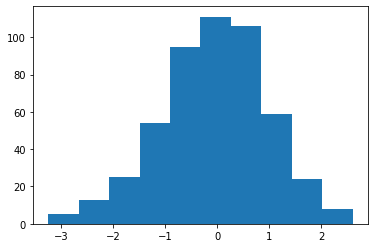

In [15]:
# generate data
n=500
data = torch.normal(torch.zeros(n), torch.ones(n))
plt.hist(data,bins=10)
plt.show()

In [158]:
-torch.distributions.Normal(0,1).log_prob(data).sum()

tensor(719.6469)

In [163]:
data.requires_grad_(False)
theta = torch.tensor(10.0,requires_grad=True)
theta.requires_grad_(True)
history = []

#explicitly compute the nll
learning_rate = 0.001
for t in range(20):
    nll = -torch.log(torch.exp(-(data-theta)**2/2)/math.sqrt(2*math.pi)).sum()
    nll.backward()
    with torch.no_grad():
        history.append([theta.clone().detach(),nll])
        theta -= learning_rate * theta.grad
        theta.grad.zero_()

In [170]:
data.requires_grad_(False)
theta = torch.tensor(10.0,requires_grad=True)
theta.requires_grad_(True)
history = []

#use the built-in normal distribution for nll
learning_rate = 0.001
for t in range(20):
    nll = -torch.distributions.Normal(theta,1).log_prob(data).sum()
    nll.backward()
    with torch.no_grad():
        history.append([theta.clone().detach(),nll])
        theta -= learning_rate * theta.grad
        theta.grad.zero_()
        #print(history[t])

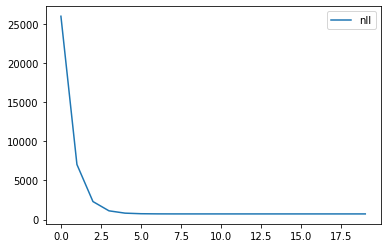

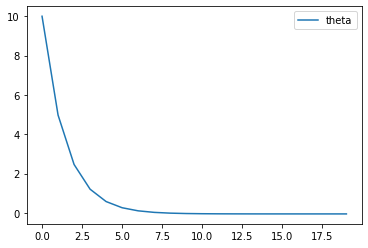

theta =  tensor(-0.0555, requires_grad=True) . nll = tensor(718.8760, grad_fn=<NegBackward0>)


In [169]:
history = torch.tensor(history)
plt.plot(history[:,1],label='nll')
plt.legend()
plt.show()
plt.plot(history[:,0],label='theta')
plt.legend()
plt.show()
print('theta = ',theta,'. nll =', nll)

# Do SR sampling estimation using pytorch

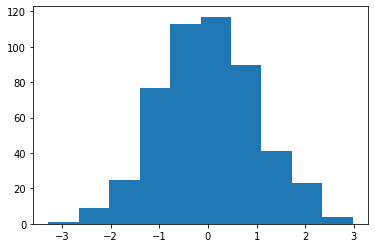

In [9]:
# generate data
n=500
data = torch.normal(torch.zeros(n), torch.ones(n))
plt.hist(data,bins=10)
plt.show()

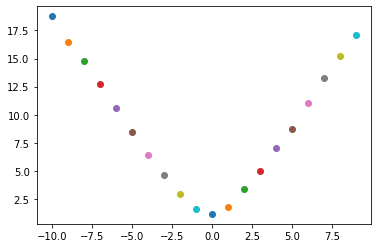

In [248]:
# SR estimation
def SR_crps(data,theta,M):
    samples = torch.distributions.Normal(0,1).sample((M,))
    samples += theta
    return 2*torch.abs(data-samples.reshape(-1,1)).mean()-(samples-samples.reshape(-1,1)).abs().float().sum()/(M*(M-1))

for k in range(-10,10):
    plt.scatter(k,SR_crps(data,k,100))

In [264]:
data.requires_grad_(False)
theta = torch.tensor(10.0,requires_grad=True)
theta.requires_grad_(True)
history = []
learning_rate = 0.1

for t in range(100):
    SR = SR_crps(data,theta,200)
    SR.backward()
    with torch.no_grad():
        history.append([theta.clone().detach(),SR])
        theta -= learning_rate*theta.grad
        theta.grad.zero_()
        if t%10==0:
            print(history[t])

[tensor(10.), tensor(18.7992, grad_fn=<SubBackward0>)]
[tensor(8.0000), tensor(14.7613, grad_fn=<SubBackward0>)]
[tensor(6.0000), tensor(11.0454, grad_fn=<SubBackward0>)]
[tensor(4.0009), tensor(7.1533, grad_fn=<SubBackward0>)]
[tensor(2.0679), tensor(3.2761, grad_fn=<SubBackward0>)]
[tensor(0.7413), tensor(1.4978, grad_fn=<SubBackward0>)]
[tensor(0.2100), tensor(1.1748, grad_fn=<SubBackward0>)]
[tensor(0.0694), tensor(1.1509, grad_fn=<SubBackward0>)]
[tensor(-0.0108), tensor(1.1549, grad_fn=<SubBackward0>)]
[tensor(-0.0297), tensor(1.1514, grad_fn=<SubBackward0>)]


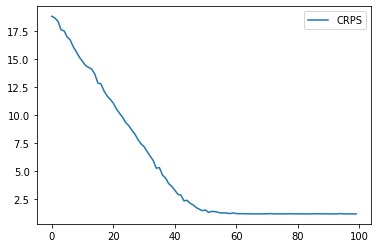

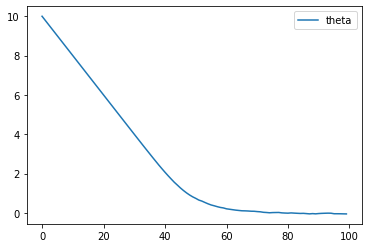

theta =  tensor(-0.0448, requires_grad=True) . CRPS = tensor(718.8760, grad_fn=<NegBackward0>)


In [265]:
history = torch.tensor(history)
plt.plot(history[:,1],label='CRPS')
plt.legend()
plt.show()
plt.plot(history[:,0],label='theta')
plt.legend()
plt.show()
print('theta = ',theta,'. CRPS =', nll)

# Copula estimation with SR using autograd

In [442]:
import numpy as np
import scipy.stats as scs
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from tqdm import tqdm
plt.rcParams.update({'font.size': 30})

# define x and y ranges and step size
x_range = np.arange(0, 10, step=1)
y_range = np.arange(0, 10, step=1)

# create grid of 2D locations using meshgrid function
xx, yy = np.meshgrid(x_range, y_range)
locations = np.column_stack((xx.ravel(), yy.ravel()))

# create distance matrix
dist_mat = distance_matrix(locations,locations)

true_theta = torch.tensor(0.5)

# generate samples
true_cov = torch.exp(-torch.square(torch.tensor(dist_mat))/(2*torch.pow(true_theta,2)))
obs = scs.multivariate_normal.rvs(mean=np.zeros(100), cov=true_cov, size=1000)

In [480]:
from scipy.spatial.distance import pdist

def Spatial_Energy_Score(beta,observations_y,simulations_Y):
    beta=torch.tensor(beta)
    n = len(observations_y)
    m = len(simulations_Y)
    observations_y = torch.tensor(observations_y)
    simulations_Y = torch.tensor(simulations_Y)
    # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
    diff_Y_y = torch.pow(
            torch.linalg.norm(
                torch.tile(observations_y,(m,1)) -
                simulations_Y,
            axis=1),
        beta)

    #Second part |Y-Y'|. 2* because pdist counts only once.
    diff_Y_Y = 2 * torch.pow(
        torch.nn.functional.pdist(simulations_Y)
    ,beta)

    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y)/(m*(m-1))
    Energy.requires_grad_(True)
    return Energy

def SR_eval(theta,beta,obs,D,M):
    sims = torch.distributions.Normal(0,1).sample((M,100)).double()@torch.linalg.cholesky(torch.exp(-torch.square(torch.tensor(dist_mat))/(2*torch.pow(theta,2)))).transpose(0,1)
    out = 0
    for row in obs:
        out+= Spatial_Energy_Score(beta,row,sims)
    return out/len(obs)

theta = torch.tensor(1.0,requires_grad=True)

for t in range(10):
    SR = SR_eval(theta,1,obs[:500],dist_mat,100)
    SR.backward()
    with torch.no_grad():
        theta -= 0.1*theta.grad
        theta.grad.zero_()
        print(theta,SR)

C:\Users\u1819911\AppData\Local\Temp\ipykernel_21808\1751444778.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  simulations_Y = torch.tensor(simulations_Y)


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [470]:
SR_eval(torch.tensor(3),1,obs[:500],dist_mat,50)

C:\Users\u1819911\AppData\Local\Temp\ipykernel_21808\3331510467.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  simulations_Y = torch.tensor(simulations_Y)


tensor(14.5113, dtype=torch.float64)

In [441]:
theta_val

tensor(3.3367)

C:\Users\u1819911\AppData\Local\Temp\ipykernel_21808\3331510467.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  simulations_Y = torch.tensor(simulations_Y)


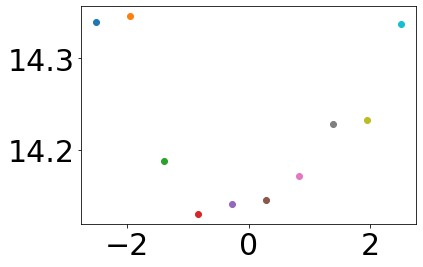

In [475]:
for theta_val in torch.linspace(-2.5,2.5,10):
    plt.scatter(theta_val,SR_eval(theta_val,1,obs[:500],dist_mat,100))

In [476]:
theta = torch.tensor(1.0,requires_grad=True)

for t in range(10):
    SR = SR_eval(theta,1,obs[:500],dist_mat,100)
    SR.backward()
    with torch.no_grad():
        theta -= 0.1*theta.grad
        theta.grad.zero_()
        print(theta,SR)

C:\Users\u1819911\AppData\Local\Temp\ipykernel_21808\3331510467.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  simulations_Y = torch.tensor(simulations_Y)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn